# implementation

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [171]:
class kohonen:

    def __init__(self, M, N, X, learning_rate=0.1, neighborhood_function="gauss"):
        self.M = M
        self.N = N
        self.learning_rate = learning_rate
        self.input_dim = X.shape[1]
        self.neighborhood_function = neighborhood_function
        self.weights = np.random.uniform(0, 1, (self.input_dim, M, N))
        minimum = np.min(X, axis=0)
        maximum = np.max(X, axis=0)
        for i in range(self.input_dim):
            self.weights[i] = minimum[i] + (maximum[i] - minimum[i]) * self.weights[i]

    def gauss_neighborhood(self, t, T):
        return np.exp(-t * t * T * T)

    def mexican_hat_neighborhood(self, t, T):
        return np.exp(-t * t * T * T) * (2 - 4 * (t * t * T * T))

    def euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)

    def slow_down(self, t, iteration_num):
        return self.learning_rate * np.exp(-t / iteration_num)

    def train(self, X, max_epochs):
        for epoch in range(max_epochs):
            X = np.random.permutation(X)
            for x in X:
                bmu = None
                bmu_distance = np.inf
                for i in range(self.M):
                    for j in range(self.N):
                        distance = self.euclidean_distance(x, self.weights[:, i, j])
                        if distance < bmu_distance:
                            bmu_distance = distance
                            bmu = (i, j)

                for i in range(self.M):
                    for j in range(self.N):
                        distance = self.euclidean_distance(
                            np.array(bmu), np.array([i, j])
                        )
                        if self.neighborhood_function == "gauss":
                            self.weights[:, i, j] += (
                                self.slow_down(epoch, max_epochs)
                                * self.gauss_neighborhood(distance, epoch)
                                * (x - self.weights[:, i, j])
                            )
                        elif self.neighborhood_function == "mexican_hat":
                            self.weights[:, i, j] += (
                                self.slow_down(epoch, max_epochs)
                                * self.mexican_hat_neighborhood(distance, epoch)
                                * (x - self.weights[:, i, j])
                            )
                        else:
                            raise ValueError("Invalid neighborhood function")

    def predict(self, X):
        return np.array(
            [
                [
                    np.argmin(
                        [
                            self.euclidean_distance(x, self.weights[:, i, j])
                            for i in range(self.M)
                            for j in range(self.N)
                        ]
                    )
                    for x in X
                ]
            ]
        ).T

In [93]:
X = pd.DataFrame(np.random.uniform(-1, 4, (10, 2)), columns=["x", "y"]).to_numpy()

In [94]:
koch = kohonen(10, 10, X)

Text(0, 0.5, 'y')

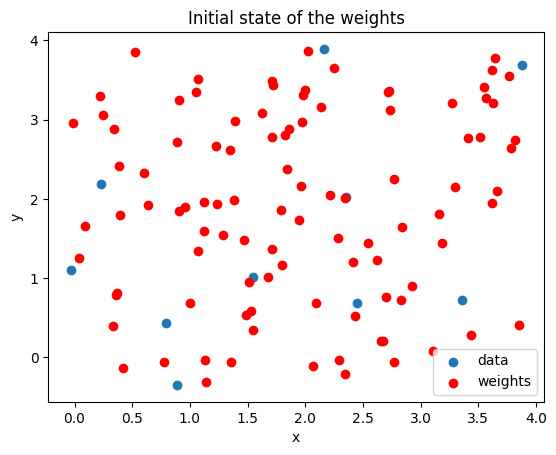

In [95]:
# plot scater plot of x
plt.scatter(X[:, 0], X[:, 1], label="data")
plt.scatter(koch.weights[0], koch.weights[1], c="red", label="weights")
plt.legend()
plt.title("Initial state of the weights")
plt.xlabel("x")
plt.ylabel("y")

### Cube data

In [161]:
cube = pd.read_csv("./../data/kohonen/cube.csv")
cube

,x,y,z,c
0,0.187781,0.239537,0.382492,0
1,-1.308979,-0.143321,-0.966648,0
2,-0.987613,0.679918,-0.037552,0
3,0.924980,0.607235,-0.146856,0
4,-0.098663,0.004329,-0.588876,0
...,...,...,...,...
1195,2.740583,3.037202,2.723101,7
1196,2.303258,4.337946,2.798172,7
1197,3.528407,4.575523,1.406155,7
1198,2.236023,3.901189,1.529630,7


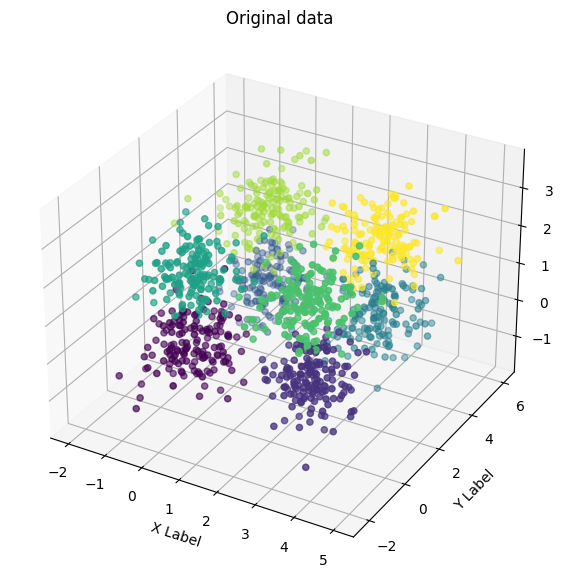

In [162]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter(cube["x"], cube["y"], cube["z"], c=cube["c"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.title.set_text("Original data")

In [177]:
cube_x = cube.drop("c", axis=1).to_numpy()
kohon = kohonen(2, 4, cube_x)
kohon.train(cube_x, 10)
cube["predicted"] = kohon.predict(cube_x)
cube

,x,y,z,c,predicted
0,0.187781,0.239537,0.382492,0,6
1,-1.308979,-0.143321,-0.966648,0,6
2,-0.987613,0.679918,-0.037552,0,6
3,0.924980,0.607235,-0.146856,0,6
4,-0.098663,0.004329,-0.588876,0,6
...,...,...,...,...,...
1195,2.740583,3.037202,2.723101,7,0
1196,2.303258,4.337946,2.798172,7,0
1197,3.528407,4.575523,1.406155,7,0
1198,2.236023,3.901189,1.529630,7,0


In [174]:
v_measure_score(cube["c"], cube["predicted"])

0.9213659041726133

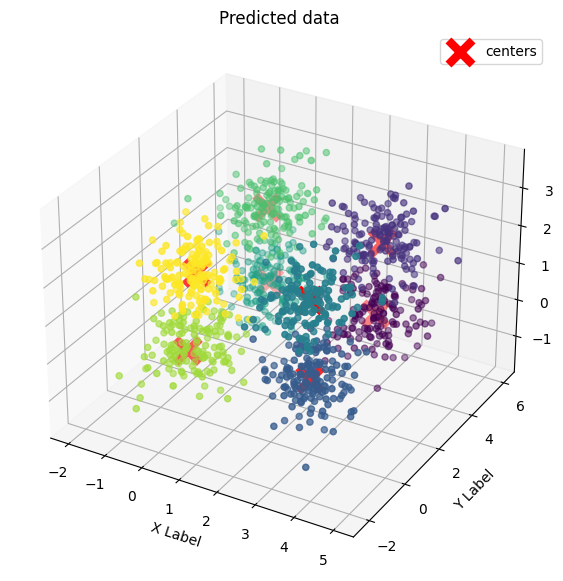

In [170]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter(cube["x"], cube["y"], cube["z"], c=cube["predicted"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.title.set_text("Predicted data")
ax.scatter(
    kohon.weights[0],
    kohon.weights[1],
    kohon.weights[2],
    c="red",
    label="centers",
    s=300,
    marker="x",
    linewidth=6,
)
plt.legend()

In [166]:
a = contingency_matrix(cube["c"], cube["predicted"])
a

array([[  0,   0,   0,   0,   0,   0, 142,   8],
       [  0,   0, 149,   1,   0,   0,   0,   0],
       [  1,   0,   0,   0, 146,   3,   0,   0],
       [142,   7,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   3, 147],
       [  0,   0,   5, 143,   0,   0,   0,   2],
       [  0,   0,   0,   0,   7, 143,   0,   0],
       [  7, 143,   0,   0,   0,   0,   0,   0]])

In [125]:
mapper = np.argmax(a, axis=1)
ma = {mapper[i]: i for i in range(len(mapper))}
cube["predicted_remapped"] = [ma[i] for i in cube["predicted"]]
cube["right"] = cube["c"] == cube["predicted_remapped"]
cube["color"] = ["green" if i else "red" for i in cube["right"]]
cube

,x,y,z,c,predicted,predicted_remapped,right,color
0,0.187781,0.239537,0.382492,0,6,0,True,green
1,-1.308979,-0.143321,-0.966648,0,6,0,True,green
2,-0.987613,0.679918,-0.037552,0,6,0,True,green
3,0.924980,0.607235,-0.146856,0,6,0,True,green
4,-0.098663,0.004329,-0.588876,0,6,0,True,green
...,...,...,...,...,...,...,...,...
1195,2.740583,3.037202,2.723101,7,4,7,True,green
1196,2.303258,4.337946,2.798172,7,4,7,True,green
1197,3.528407,4.575523,1.406155,7,4,7,True,green
1198,2.236023,3.901189,1.529630,7,4,7,True,green


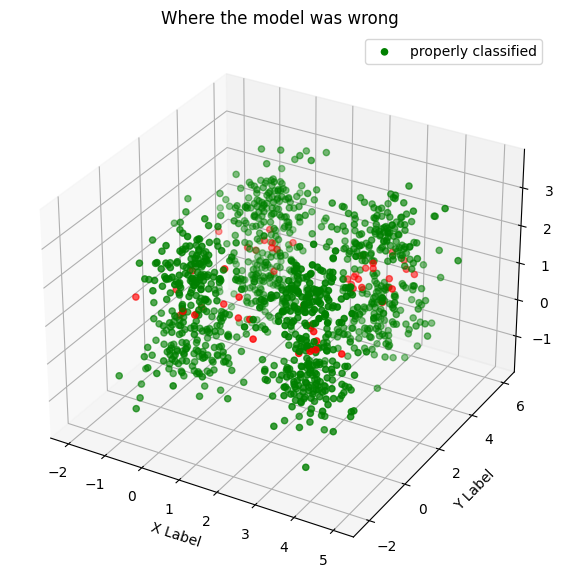

In [133]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter(cube["x"], cube["y"], cube["z"], c=cube["color"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.title.set_text("Where the model was wrong")
plt.legend(["properly classified"])

### hexagon

In [178]:
hex = pd.read_csv("./../data/kohonen/hexagon.csv")
hex

,x,y,c
0,2.402047,3.728695,1
1,-0.660032,7.047206,0
2,2.202839,-2.394303,2
3,3.179183,2.593885,1
4,3.173320,-2.152688,2
...,...,...,...
595,-2.186246,-4.059754,4
596,4.089715,-2.879358,2
597,-3.014489,-2.824257,4
598,3.746346,3.001876,1


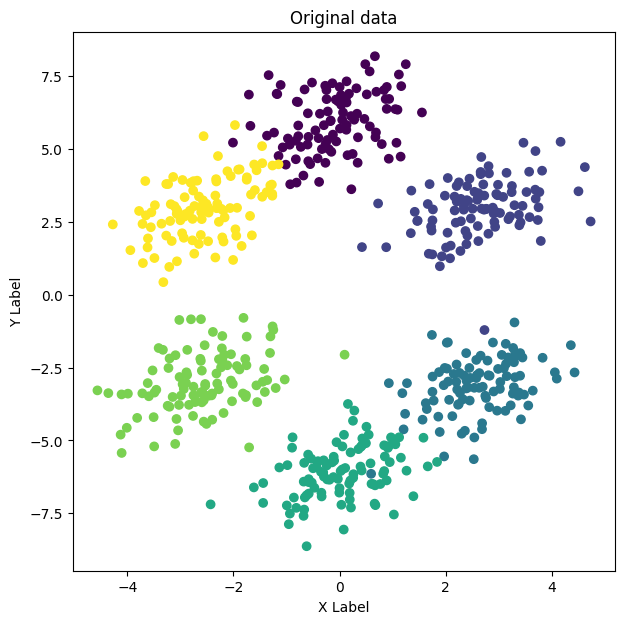

In [143]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.scatter(hex["x"], hex["y"], c=hex["c"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.title.set_text("Original data")

In [179]:
hex_x = hex.drop("c", axis=1).to_numpy()
kohon = kohonen(2, 3, hex_x)
kohon.train(hex_x, 10)
hex["predicted"] = kohon.predict(hex_x)
v_measure_score(hex["c"], hex["predicted"])

0.9383662598182815

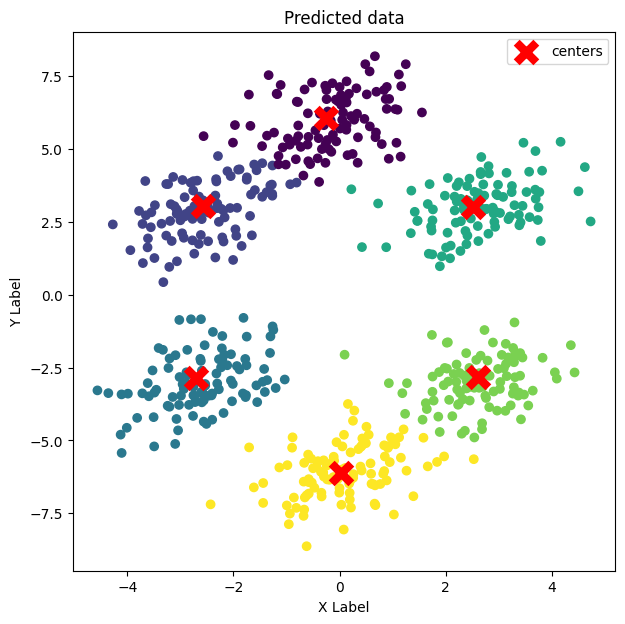

In [156]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.scatter(hex["x"], hex["y"], c=hex["predicted"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.title.set_text("Predicted data")
ax.scatter(
    kohon.weights[0],
    kohon.weights[1],
    c="red",
    label="centers",
    s=200,
    marker="x",
    linewidth=6,
)
plt.legend()

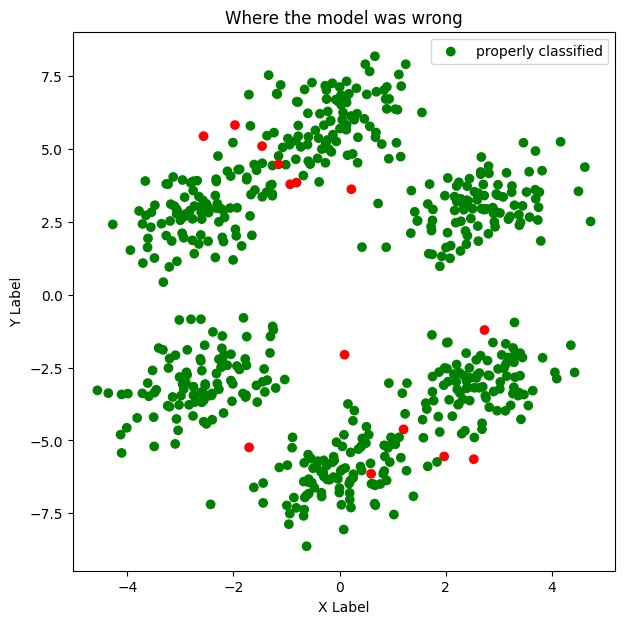

In [147]:
a = contingency_matrix(hex["c"], hex["predicted"])
mapper = np.argmax(a, axis=1)
ma = {mapper[i]: i for i in range(len(mapper))}
hex["predicted_remapped"] = [ma[i] for i in hex["predicted"]]
hex["right"] = hex["c"] == hex["predicted_remapped"]
hex["color"] = ["green" if i else "red" for i in hex["right"]]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.scatter(hex["x"], hex["y"], c=hex["color"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.title.set_text("Where the model was wrong")
plt.legend(["properly classified"])